# Context

## Challenge
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

File descriptions

# train_users.csv - the training set of users

# test_users.csv - the test set of users

id: user id

date_account_created: the date of account creation

timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up

date_first_booking: date of first booking

gender

age

signup_method

signup_flow: the page a user came to signup up from

language: international language preference

affiliate_channel: what kind of paid marketing

affiliate_provider: where the marketing is e.g. google, craigslist, other

first_affiliate_tracked: whats the first marketing the user interacted with before the signing up

signup_app

first_device_type

first_browser

country_destination: this is the target variable you are to predict

# sessions.csv - web sessions log for users

user_id: to be joined with the column 'id' in users table

action

action_type

action_detail

device_type

secs_elapsed

countries.csv - summary statistics of destination countries in this dataset and their locations

age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination

sample_submission.csv - correct format for submitting your predictions


# 1. Imports

## 1.1. Libraries

In [1]:
# Jupyter settings
from IPython.core.display      import display, HTML
from IPython.display           import Image

# data manipulation
import inflection
import datetime
import math
import random
import numpy as np
import pandas as pd
from scipy import stats as ss

# EDA
import pandas_profiling as pr
import seaborn as sns
import matplotlib.pyplot as plt

# feature selection
from boruta import BorutaPy

# balancing
from imblearn   import combine         as c

# ML models
from sklearn import ensemble as en
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from category_encoders import TargetEncoder
from sklearn import metrics         as m
from scikitplot import metrics      as mt


# neural nets
from keras import models as ml
from keras import layers as l

## 1.2. Helper Functions

In [2]:
# jupyter setup
def jupyter_settings():
    
    # jupyter core settings
    display(HTML("<style>.container { width:100% !important; }</style>"))
    !pylab inline
    
    # pandas
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.expand_frame_repr', False)
    
    # matplotlib
    !matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [35, 12]
    plt.rcParams['font.size'] = 30
    
    # seaborn
    sns.set()
    
    
# descriptive analysis summary for numerical features
def num_analysis(num_attributes):
    # Cemtral tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
    
    # histogram
    hist = num_attributes.hist(bins=30)
    
    return m

    return hist


def cramer_v (x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

In [3]:
jupyter_settings()

'pylab' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
'matplotlib' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 1.3. Data

In [10]:
# train_users_2

df_raw = pd.read_csv('data/train_users_2.csv')
df_raw.shape

(213451, 16)

In [11]:
# sessions

df_sessions = pd.read_csv('data/sessions.csv')
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [12]:
# granulariadade, cada usuario realiza varias ações, como registrado no csv 'sessions'
df_sessions.sort_values('user_id').head()
# cada ação pode ser convertida a uma nova variável, com indicação de ocorrência ou não por parte do usuário

,user_id,action,action_type,action_detail,device_type,secs_elapsed
3573962,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,1767.0
3573933,00023iyk9l,requested,view,p5,Mac Desktop,702.0
3573934,00023iyk9l,requested,view,p5,Mac Desktop,3827.0
3573935,00023iyk9l,travel_plans_current,view,your_trips,Mac Desktop,474.0
3573949,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,922.0


In [13]:
df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].groupby('user_id').count()

,action
user_id,
00023iyk9l,39


In [15]:
pd.DataFrame(df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].value_counts()).T

user_id 00023iyk9l                                                                                                                                                               
action        show requested personalize index dashboard similar_listings travel_plans_current header_userpic ajax_refresh_subtotal search_results pending confirm_email callback
0                9         5           4     4         4                3                    2              2                     2              1       1             1        1

# 2. Descriptive analysis

In [173]:
df1 = df_raw.copy()
df1

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [138]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 213451
Number of Columns: 16


In [139]:
df1.sample()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
70331,d5swhjee2s,2013-04-11,20130411034546,NaN,MALE,35.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF


In [132]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [133]:
df1.isna().sum() / len(df1)

# date_first_booking         
# age         
# first_affiliate_tracked    

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [134]:
df_sessions.isna().sum() / len(df_sessions)

# user_id          0.003264
# action           0.007535
# action_type      0.106570
# action_detail    0.106570
# device_type      0.000000
# secs_elapsed     0.012872

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## Fill NA

In [140]:
# ========================= Users ===========================
# date_first_booking   : the maximum datetime value is correspondent to what would be the current present date, in this dataset it is 2015-06-29
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age         
df1 = df1[(df1['age']>15) & (df1['age']<120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked   
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ======================= Sessions =========================
# user_id          0.003264
# df_sessions = df_sessions[~df_sessions['user_id'].isna()]
# action           0.007535
# df_sessions = df_sessions[~df_sessions['action'].isna()]
# action_type      0.106570
# df_sessions = df_sessions[~df_sessions['action_type'].isna()]
# action_detail    0.106570
# df_sessions = df_sessions[~df_sessions['action_detail'].isna()]
# device_type      0.000000
# df_sessions = df_sessions[~df_sessions['device_type'].isna()]
# secs_elapsed     0.012872
# df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

<ipython-input-140-86834550d63a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['age'] = df1['age'].fillna(avg_age)


### Data Types

In [141]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [142]:
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])       
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format = '%Y%m%d%H%M%S')         
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])  
df1['age'] = df1['age'].astype(int)

In [143]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Df1 - Users

In [40]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [41]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( include=['object'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


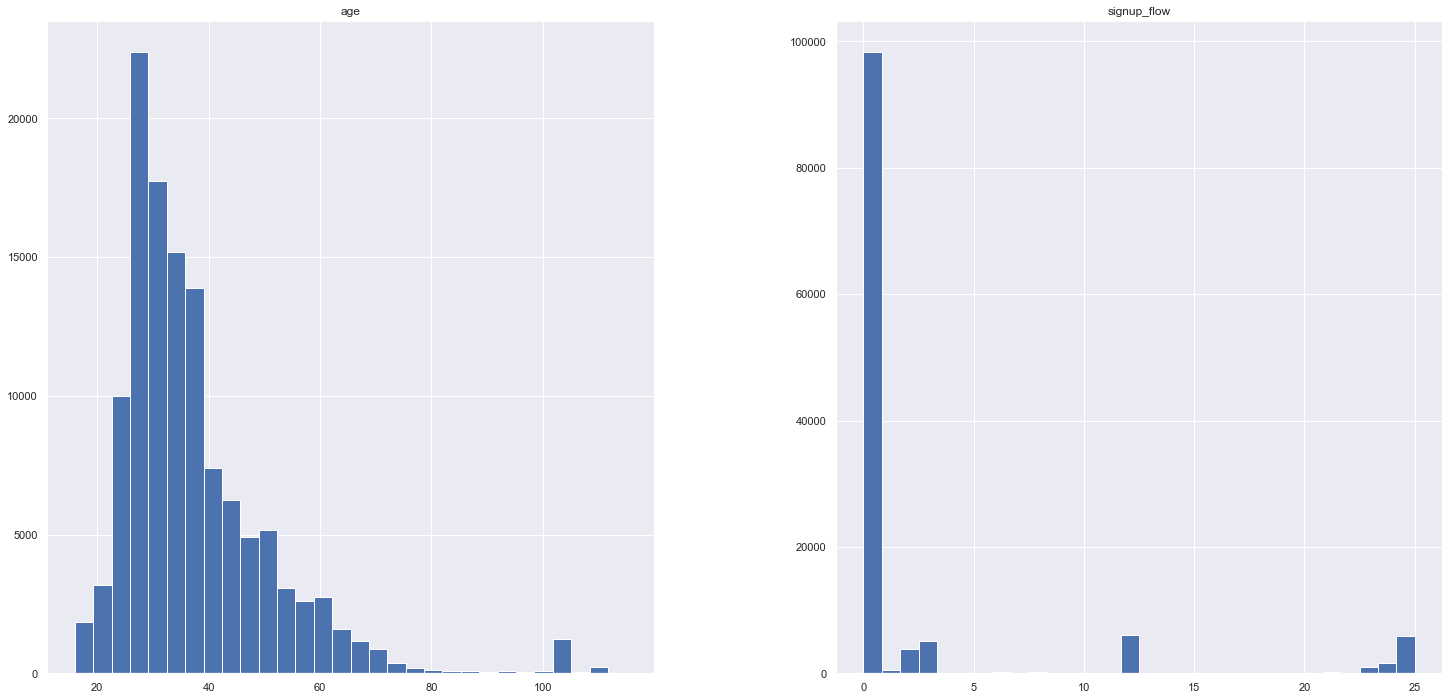

In [42]:
num_analysis(num_attributes)

In [43]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


In [34]:
cat_attributes['gender'].unique()

array(['MALE', 'FEMALE', '-unknown-', 'OTHER'], dtype=object)

In [35]:
cat_attributes['language'].unique()

array(['en', 'de', 'fr', 'es', 'zh', 'ko', 'it', 'ru', 'ja', 'pt', 'nl',
       'sv', 'pl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'el', 'th', 'cs',
       'hr', 'ca', 'is'], dtype=object)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Mac Desktop'),
  Text(1, 0, 'Windows Desktop'),
  Text(2, 0, 'iPhone'),
  Text(3, 0, 'Desktop (Other)'),
  Text(4, 0, 'Android Tablet'),
  Text(5, 0, 'Other/Unknown'),
  Text(6, 0, 'iPad'),
  Text(7, 0, 'Android Phone'),
  Text(8, 0, 'SmartPhone (Other)')])

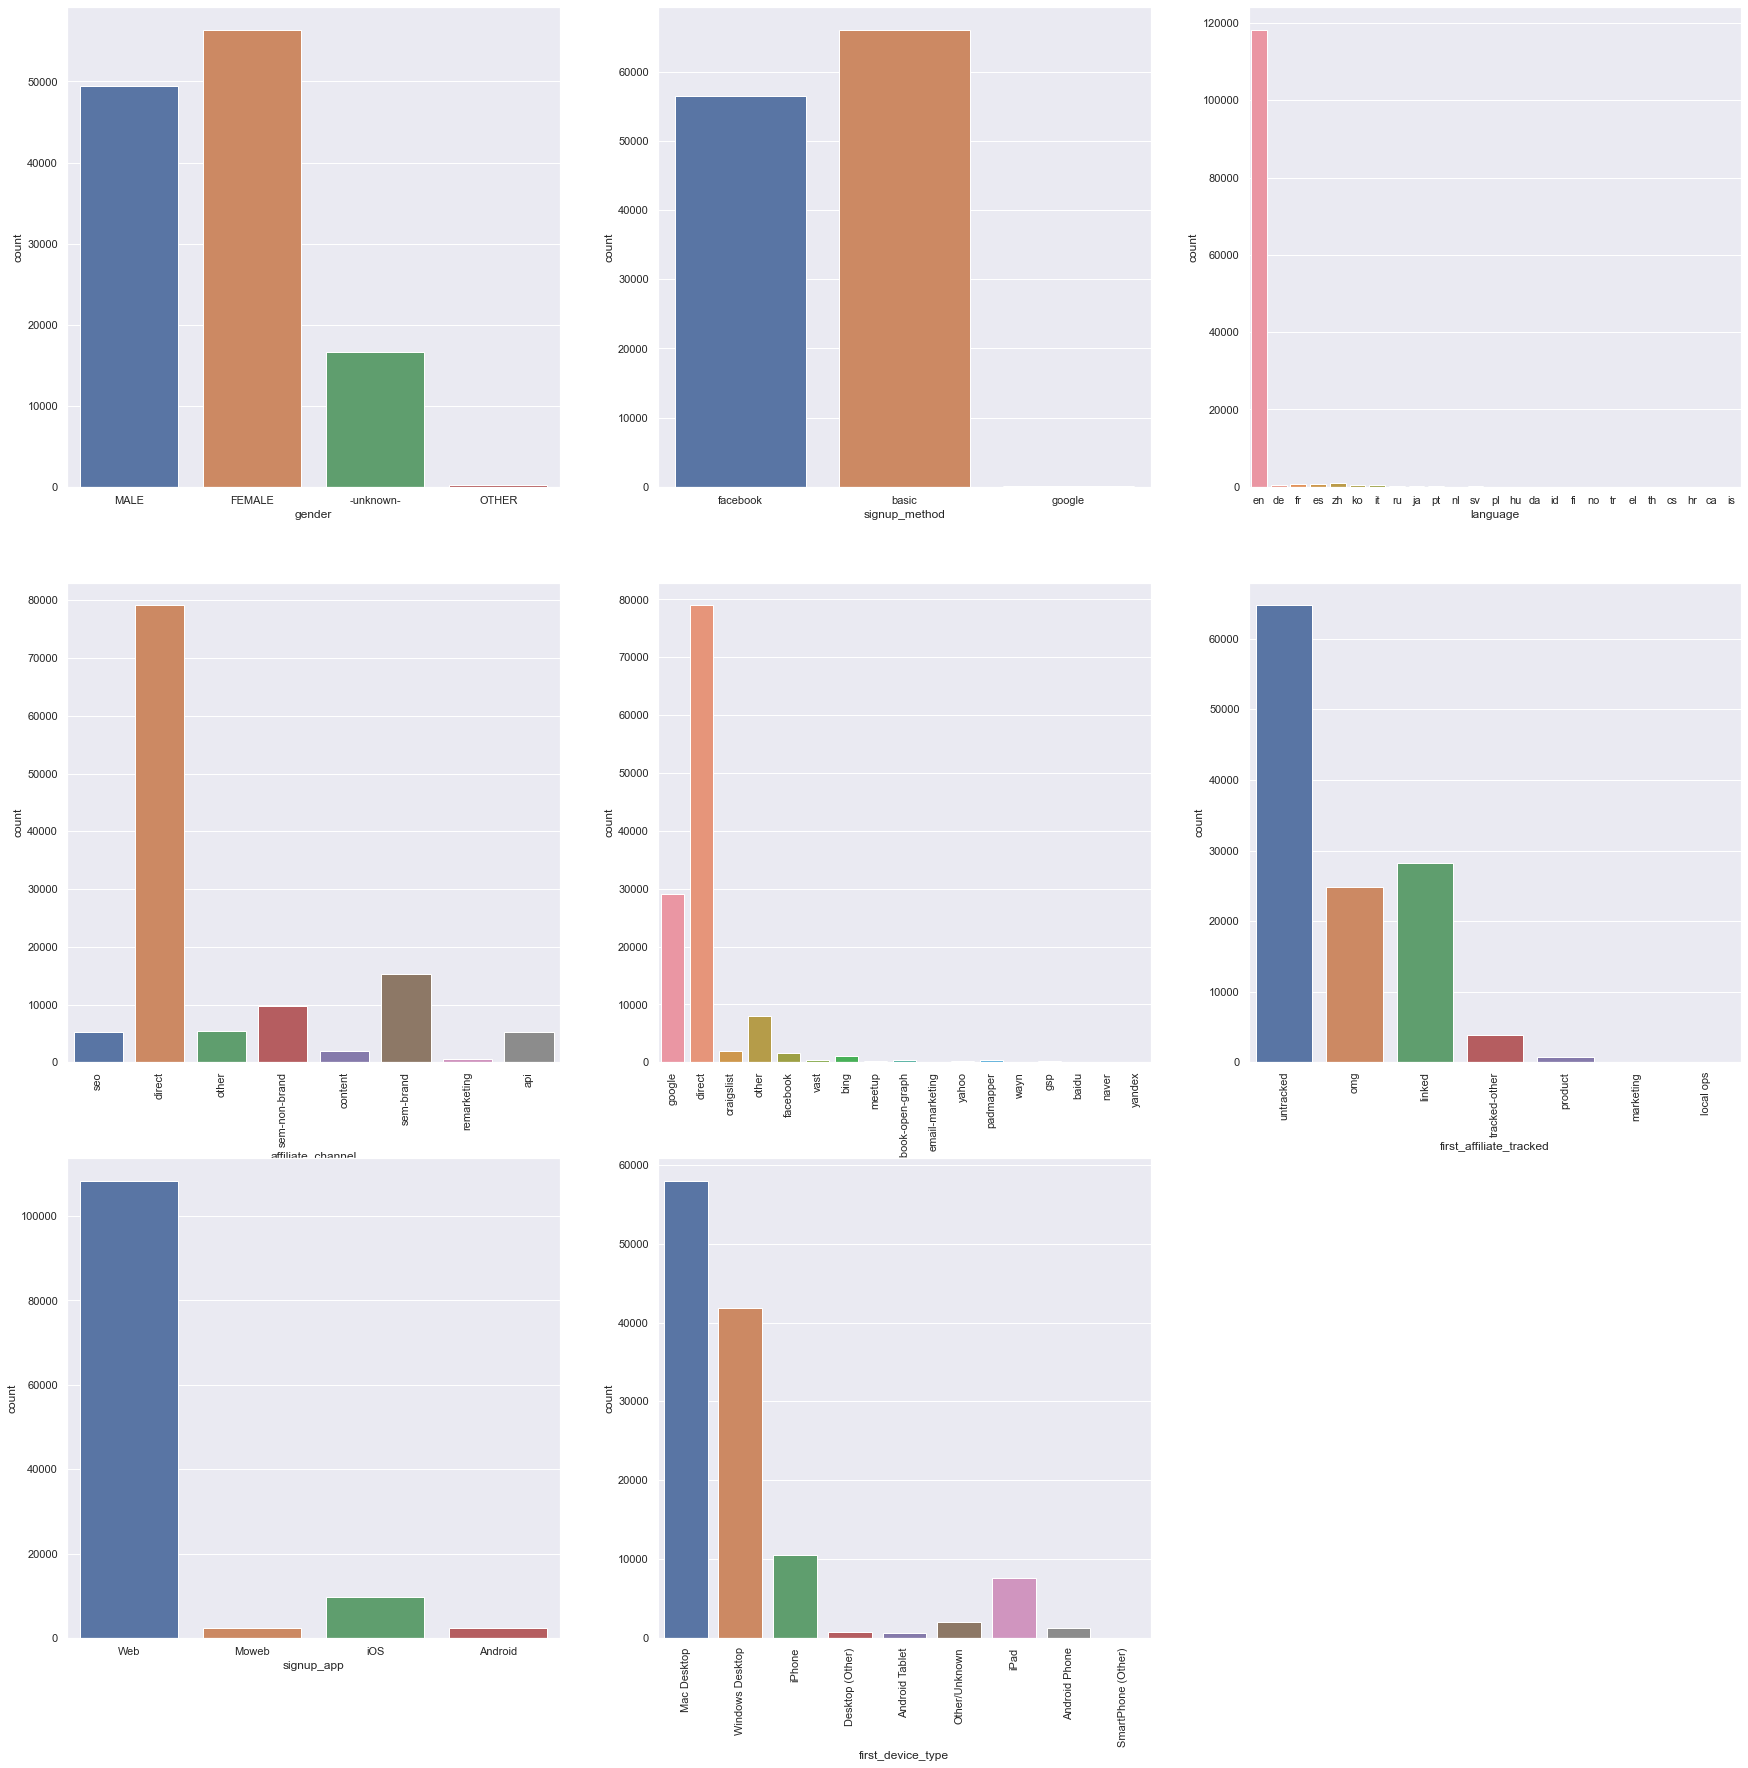

In [76]:
plt.figure(figsize=(30, 30))
plt.xticks()

plt.subplot(3,3,1)
sns.countplot(x='gender',data=cat_attributes)

plt.subplot(3,3,2)
sns.countplot(x='signup_method',data=cat_attributes)

plt.subplot(3,3,3)
sns.countplot(x='language',data=cat_attributes)

plt.subplot(3,3,4)
sns.countplot(x='affiliate_channel',data=cat_attributes)
plt.xticks(rotation=90)

plt.subplot(3,3,5)
sns.countplot(x='affiliate_provider',data=cat_attributes)
plt.xticks(rotation=90)

plt.subplot(3,3,6)
sns.countplot(x='first_affiliate_tracked',data=cat_attributes)
plt.xticks(rotation=90)

plt.subplot(3,3,7)
sns.countplot(x='signup_app',data=cat_attributes)

plt.subplot(3,3,8)
sns.countplot(x='first_device_type',data=cat_attributes)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='country_destination', ylabel='count'>

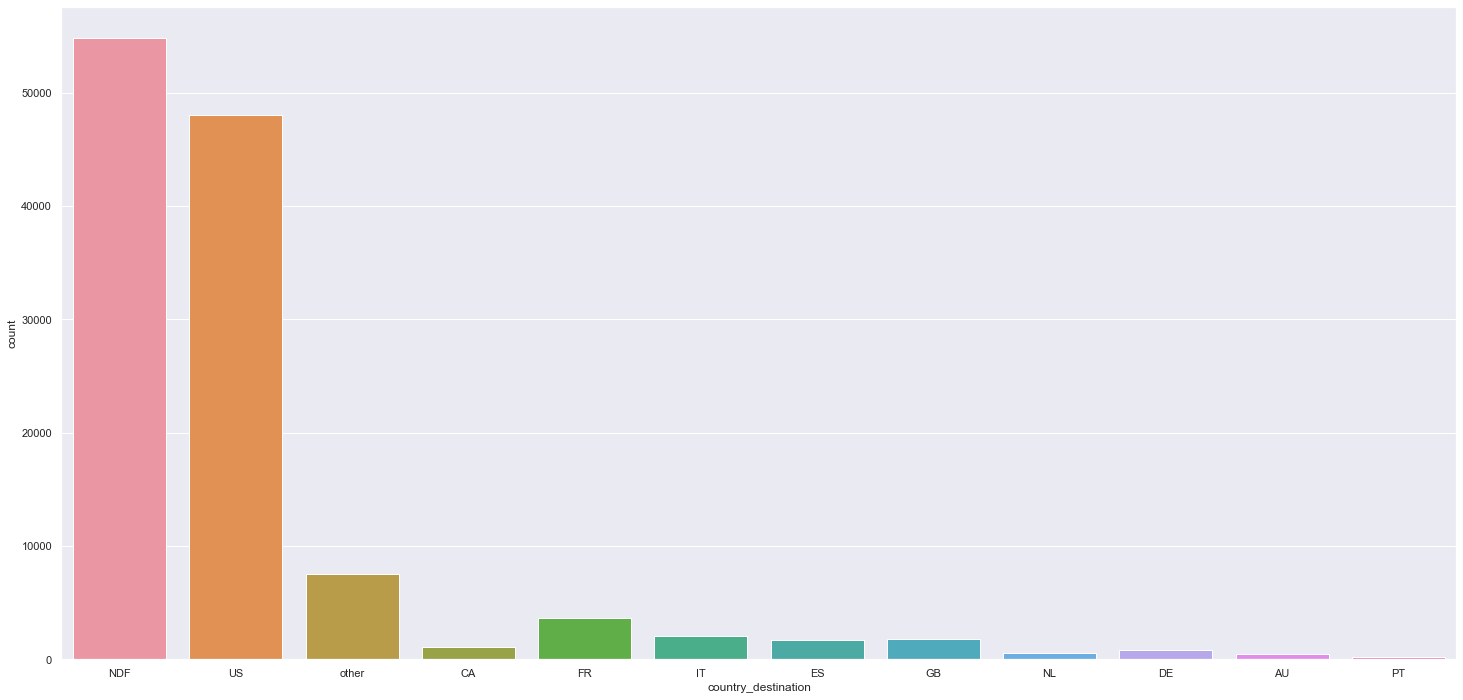

In [63]:
sns.countplot(x='country_destination',data=cat_attributes)

c:\users\lucas\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='language', ylabel='count'>

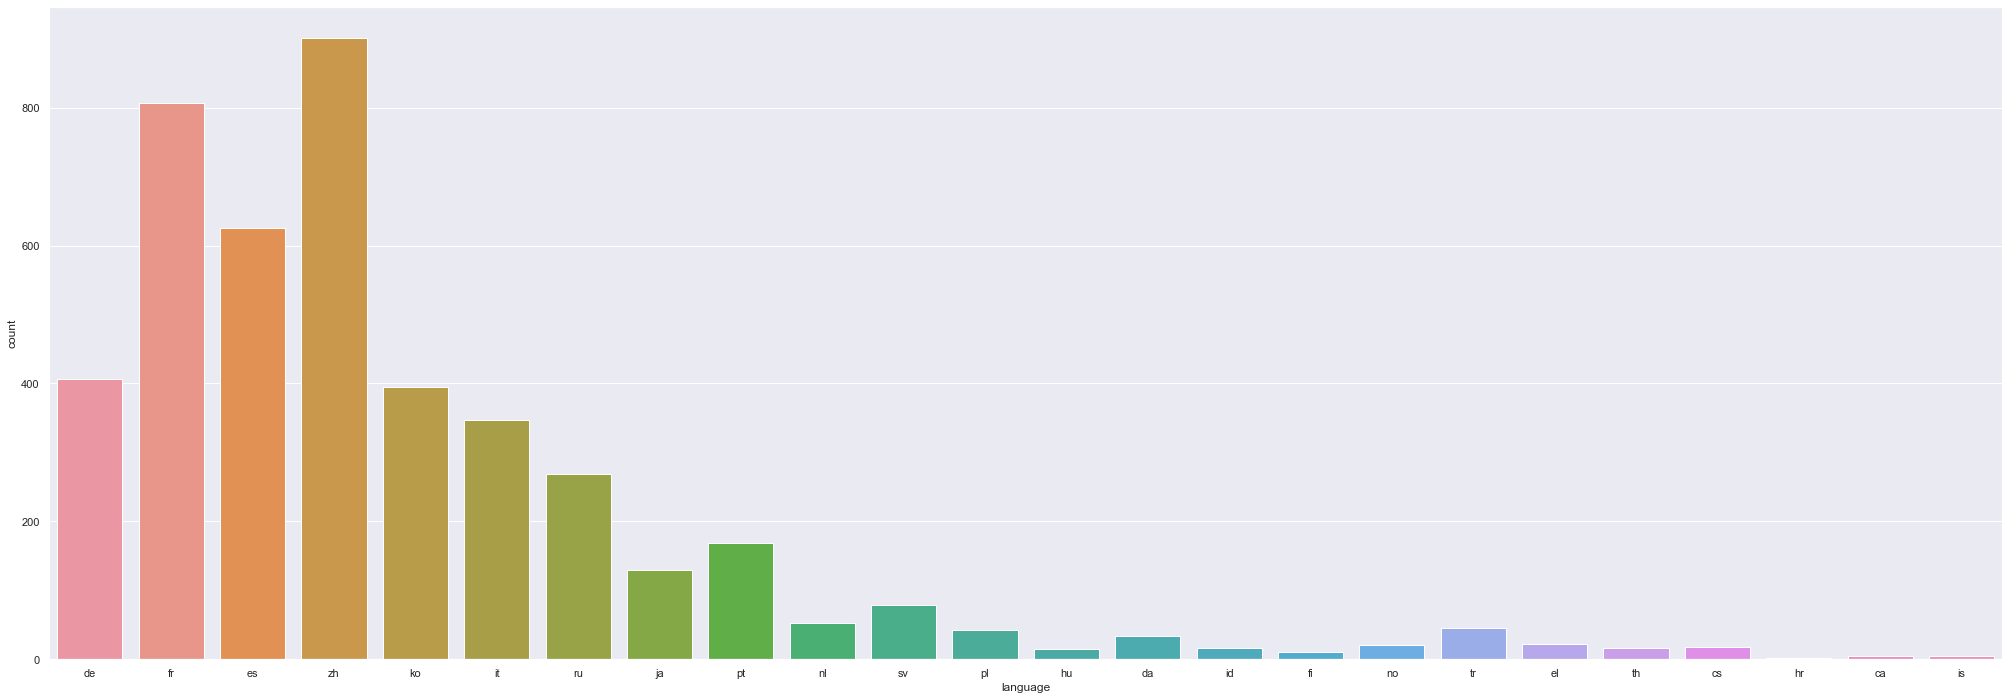

In [73]:
aux = cat_attributes['language'][cat_attributes['language'] != 'en']
sns.countplot(aux)

In [45]:
time_attributes.describe()

<ipython-input-45-6d2f1968cb9d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  time_attributes.describe()
<ipython-input-45-6d2f1968cb9d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  time_attributes.describe()
<ipython-input-45-6d2f1968cb9d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  time_attributes.describe()


,date_account_created,timestamp_first_active,date_first_booking
count,122636,122636,122636
unique,1617,122636,1938
top,2014-06-24 00:00:00,2013-07-02 18:05:32,2015-06-29 00:00:00
freq,368,1,54853
first,2010-01-02 00:00:00,2009-05-23 17:48:09,2010-01-04 00:00:00
last,2014-06-30 00:00:00,2014-06-30 23:57:54,2015-06-29 00:00:00


In [79]:
cat_list = cat_attributes.drop('id', axis=1).columns.tolist()
corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # correlation
        corr = cramer_v (cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
        
    # append a correlation list for each ref attributes
    corr_dict[ref] = corr_list

<AxesSubplot:>

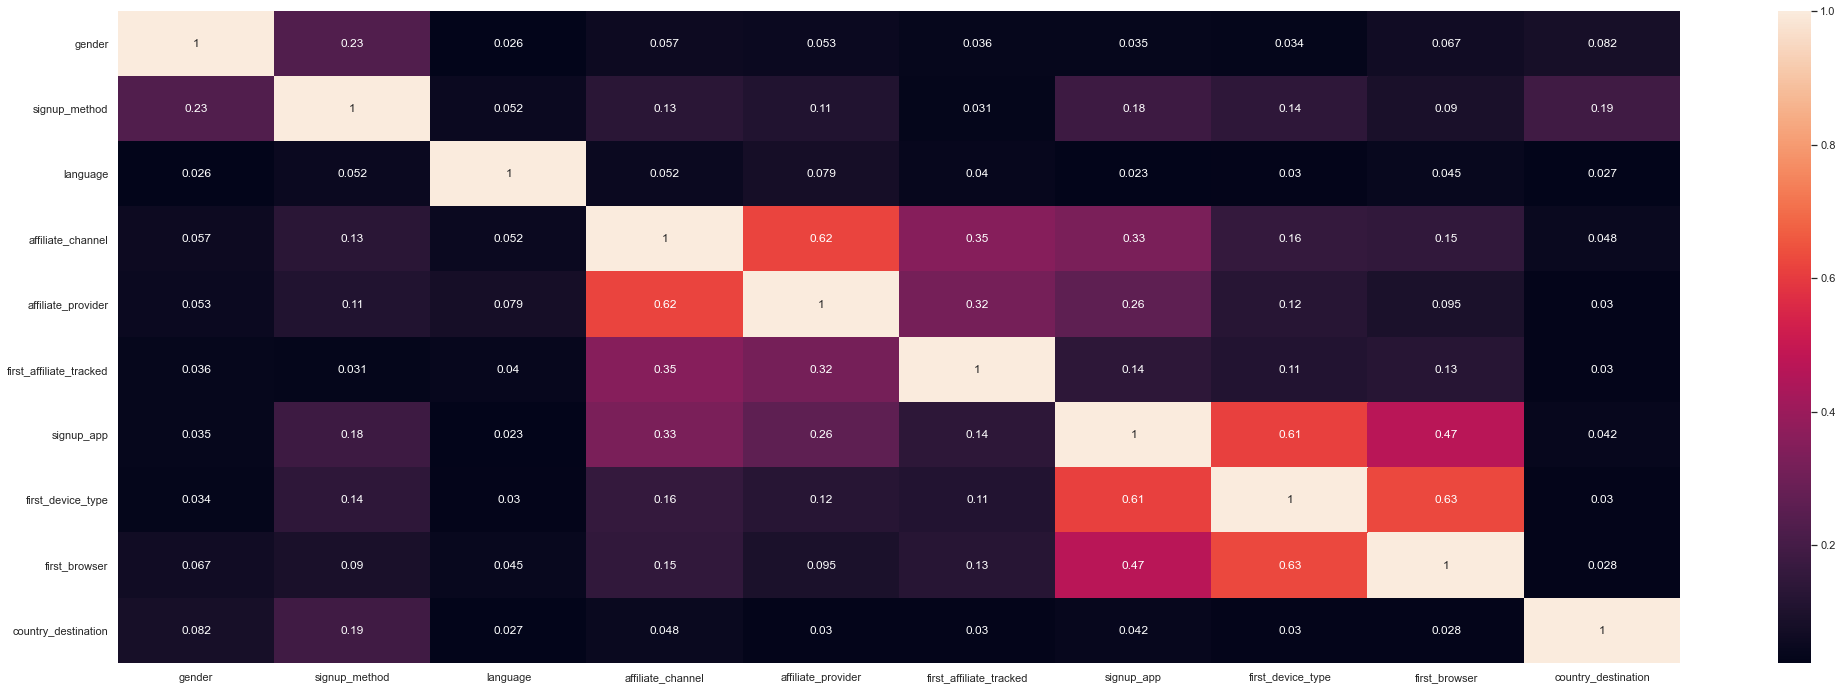

In [89]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 3. Feature Engineering

In [146]:
df2 = df1.copy()

In [145]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [149]:
df2[['date_account_created', 'timestamp_first_active', 'date_first_booking']].describe()

<ipython-input-149-a6921e7b3dc6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2[['date_account_created', 'timestamp_first_active', 'date_first_booking']].describe()
<ipython-input-149-a6921e7b3dc6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2[['date_account_created', 'timestamp_first_active', 'date_first_booking']].describe()
<ipython-input-149-a6921e7b3dc6>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and 

,date_account_created,timestamp_first_active,date_first_booking
count,122636,122636,122636
unique,1617,122636,1938
top,2014-06-24 00:00:00,2013-07-02 18:05:32,2015-06-29 00:00:00
freq,368,1,54853
first,2010-01-02 00:00:00,2009-05-23 17:48:09,2010-01-04 00:00:00
last,2014-06-30 00:00:00,2014-06-30 23:57:54,2015-06-29 00:00:00


In [151]:
pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))

1        2009-05-23
2        2009-06-09
3        2009-10-31
4        2009-12-08
6        2010-01-02
            ...    
213441   2014-06-30
213443   2014-06-30
213445   2014-06-30
213446   2014-06-30
213448   2014-06-30
Name: timestamp_first_active, Length: 122636, dtype: datetime64[ns]

In [152]:
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))

# creating new features from 'date_account_created', 'timestamp_first_active', 'date_first_booking'
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

# ================== First Active ==================
df2['year_first_active'] = df2['first_active'].dt.year
df2['month_first_active'] = df2['first_active'].dt.month
df2['day_first_active'] = df2['first_active'].dt.day
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================
df2['year_first_booking'] = df2['date_first_booking'].dt.year
df2['month_first_booking'] = df2['date_first_booking'].dt.month
df2['day_first_booking'] = df2['date_first_booking'].dt.day
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created ================
df2['year_account_created'] = df2['date_account_created'].dt.year
df2['month_account_created'] = df2['date_account_created'].dt.month
df2['day_account_created'] = df2['date_account_created'].dt.day
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

<ipython-input-152-856f72e1976a>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
<ipython-input-152-856f72e1976a>:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
<ipython-input-152-856f72e1976a>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# 4. Filter

In [159]:
df3 = df2.copy()

### 4.1. Filtering rows

In [160]:
df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

### 4.2. Columns

In [161]:
 cols_drop = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 
        'first_active'] # original datetime

# 6. Encoding

In [162]:
df5 = df3.copy()
df5.shape

(122636, 35)

In [163]:
df5.dtypes

id                                                       object
date_account_created                             datetime64[ns]
timestamp_first_active                           datetime64[ns]
date_first_booking                               datetime64[ns]
gender                                                   object
age                                                       int32
signup_method                                            object
signup_flow                                               int64
language                                                 object
affiliate_channel                                        object
affiliate_provider                                       object
first_affiliate_tracked                                  object
signup_app                                               object
first_device_type                                        object
first_browser                                            object
country_destination                     

In [164]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical and categorical columns
col_num = df5.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
col_cat = df5.select_dtypes(exclude=['int32' ,'int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df5_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df5.index)

# join numerical and categorical
df52 = pd.concat([df5[col_num], df5_dummy], axis=1)
df52.shape

(122636, 138)

In [165]:
df52

,age,signup_flow,days_from_first_active_until_booking,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117
1,38,0,2228,732,1496,2009,5,23,5,21,2015,6,29,0,27,2011,5,25,2,21,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,56,3,419,476,-57,2009,6,9,1,24,2010,8,2,0,31,2010,9,28,1,39,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42,0,1043,765,278,2009,10,31,5,44,2012,9,8,5,36,2011,12,5,0,49,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41,0,72,280,-208,2009,12,8,1,50,2010,2,18,3,7,2010,9,14,1,37,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,46,0,3,0,3,2010,1,2,5,53,2010,1,5,1,1,2010,1,2,5,53,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

# 7. Balancing Response Variable

In [174]:
ratio_balanced = {'NDF': 54852,
                  'US':  54852,
                  'other': 54852,
                  'FR': 54852,
                  'IT': 54852,
                  'GB': 54852,
                  'ES': 54852,
                  'CA': 54852,
                  'DE': 54852,
                  'NL': 54852,
                  'AU': 54852,
                  'PT': 54852}
    
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df52, df3['country_destination'])

In [175]:
y_smt.value_counts()

PT       54852
AU       54851
NL       54851
NDF      54850
CA       54843
DE       54842
GB       54814
IT       54813
ES       54809
FR       54756
other    54605
US       54490
Name: country_destination, dtype: int64

In [176]:
# numerical data
df63 = X_smt[col_num]

# categorical data
df64 = X_smt.drop(col_num, axis=1)
df65 = pd.DataFrame(ohe.inverse_transform(df64), columns=col_cat, index=df64.index)

# join numerical categorical
df66 = pd.concat([df63, df65], axis=1)
df66['country_destination'] = y_smt

# 8. EDA

In [183]:
# Unbalanced
df81 = pd.concat([df52, df3['country_destination']], axis=1)
# Balanced
df82 = df66.copy()

In [189]:
# df81.to_csv('df81.csv')
# df82.to_csv('df82.csv')
# df81 = pd.read_csv('df81.csv')
# df82 = pd.read_csv('df82.csv')

## Unbalanced

####  Hypothesis 01. The average time from first active to first booking is under 15 days, for all destinies.

* TRUE

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

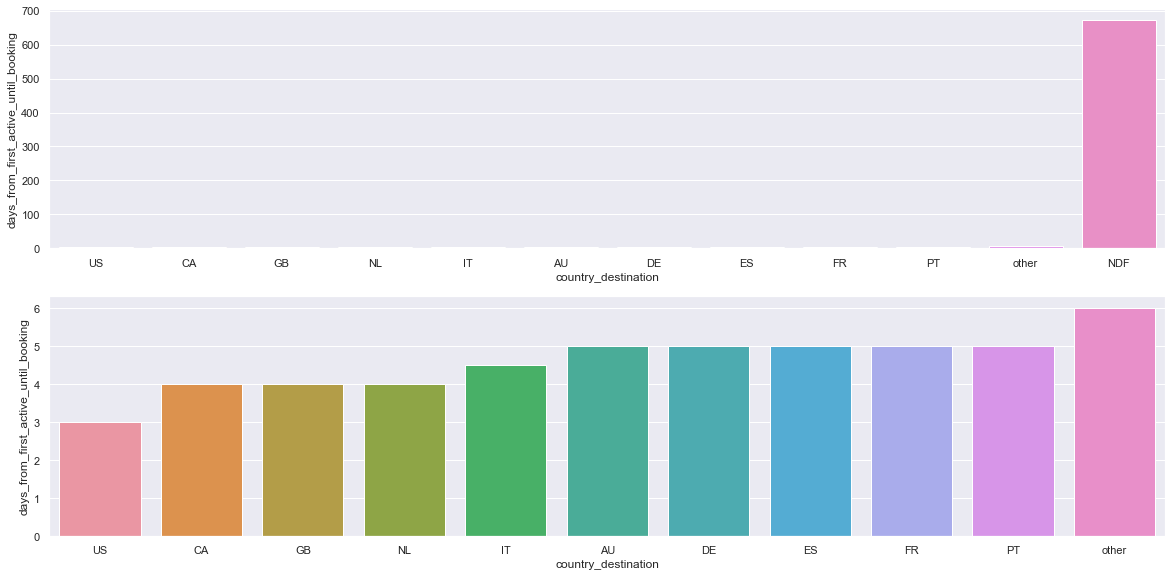

In [194]:
plt.figure( figsize=(20, 15))
plt.subplot( 3, 1, 1 )
aux01 = df81[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values( 'days_from_first_active_until_booking' ) )

# remove outlier
plt.subplot( 3, 1, 2 )
aux02 = df81[df81['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', data=aux02.sort_values( 'days_from_first_active_until_booking' ) )

####  Hypothesis 02. Users take, on average, less than 3 days to create an account.

* TRUE

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

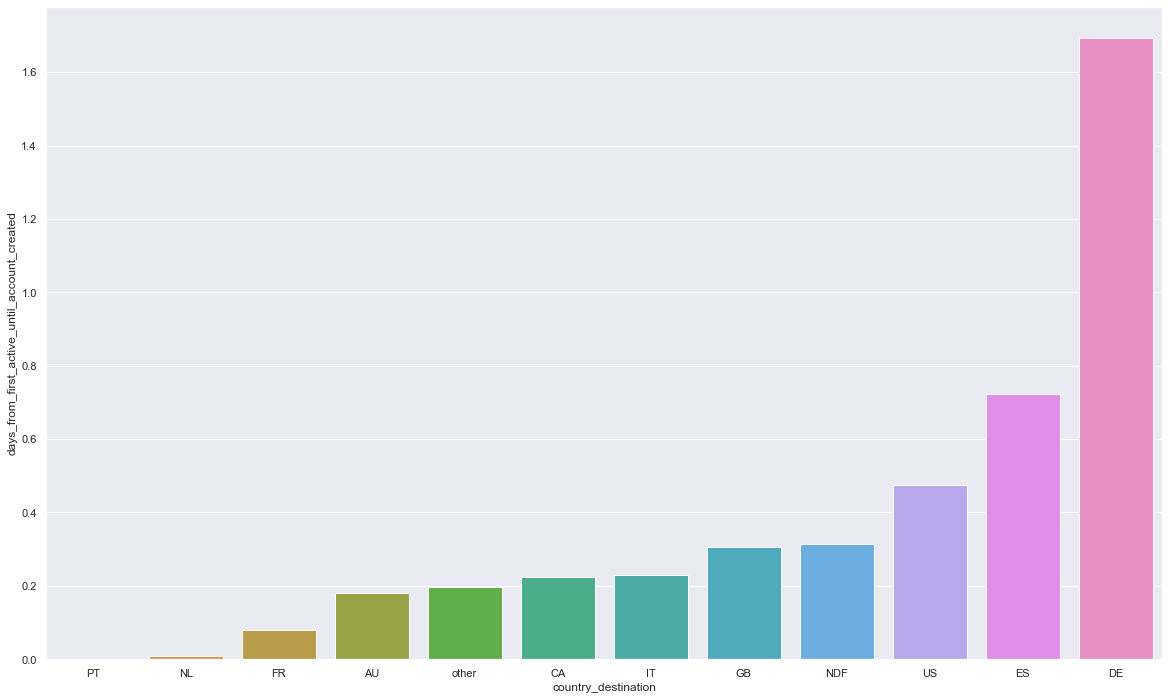

In [188]:
plt.figure( figsize=(20, 12))
aux01 = df81[['days_from_first_active_until_account_created', 'country_destination']].groupby( 'country_destination' ).mean().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_account_created', data=aux01.sort_values( 'days_from_first_active_until_account_created' ) )

####  Hypothesis 03. The number of annual reserves increased 20% during summer in the US

* FALSE

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

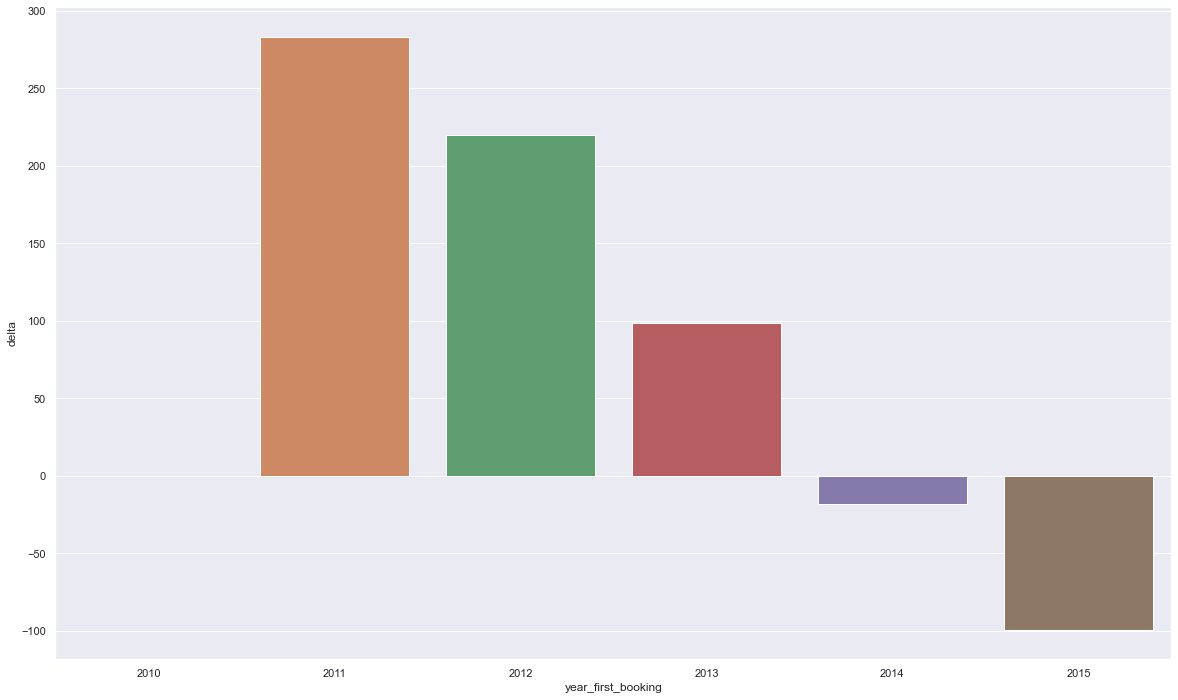

In [190]:
aux01 = df81[['year_first_booking', 'month_first_booking', 'country_destination']].groupby( ['year_first_booking', 'month_first_booking', 'country_destination'] ).size().reset_index().rename( columns={0:'count'})
# select only summer
aux01 = aux01[(aux01['month_first_booking'].isin( [6, 7, 8, 9])) & (aux01['country_destination'] == 'US')]
aux02 = aux01[['year_first_booking', 'count']].groupby( 'year_first_booking' ).sum().reset_index()
aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)
plt.figure(figsize=(20,12))
sns.barplot(x='year_first_booking', y='delta', data=aux02)

## Balanced

In [192]:
profile = pr.ProfileReport(df82, title='Airbnb Booking' )
#profile.to_notebook_iframe()
profile.to_file(output_file='airbnb_booking_statistics_after_cleaning.html')

In [201]:
# ===================== High Correlation between features justifies dropping columns before feature selection ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking   # Remove: days_from_first_active_until_booking
# year_first_active x year_account_created                                               # Remove: year_first_active
# month_first_active x month_account_created                                             # Remove: month_first_active
# day_first_active x day_account_created                                                 # Remove: day_first_active
# day_of_week_first_active x day_of_week_account_created                                 # Remove: day_of_week_first_active
# week_of_year_first_active x week_of_year_account_created                               # Remove: week_of_year_first_active
# month_first_booking x week_of_year_first_booking                                       # Remove: month_first_booking
# month_account_created x week_of_year_account_created                                   # Remove: month_account_created
# year_first_booking x year_account_created                                              # Remove: year_first_booking
# week_of_year_first_booking x week_of_year_account_created                              # Remove: week_of_year_first_booking
# affiliate_channel x affiliate_provider                                                 # Remove: affiliate_provider
# first_device_type x first_browser                                                      # Remove: first_browser
#first_device_type x sigup_app                                                           # Remove: first_device_type

cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
        'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language'] # high correlation

# 9. Data Preparation

In [198]:
df82

,age,signup_flow,days_from_first_active_until_booking,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,38,0,2228,732,1496,2009,5,23,5,21,2015,6,29,0,27,2011,5,25,2,21,MALE,facebook,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
1,56,3,419,476,-57,2009,6,9,1,24,2010,8,2,0,31,2010,9,28,1,39,FEMALE,basic,en,direct,direct,untracked,Web,Windows Desktop,IE,US
2,42,0,1043,765,278,2009,10,31,5,44,2012,9,8,5,36,2011,12,5,0,49,FEMALE,facebook,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
3,41,0,72,280,-208,2009,12,8,1,50,2010,2,18,3,7,2010,9,14,1,37,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
4,46,0,3,0,3,2010,1,2,5,53,2010,1,5,1,1,2010,1,2,5,53,FEMALE,basic,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657371,32,0,6,0,6,2013,4,7,0,15,2013,4,13,3,15,2013,4,7,0,15,MALE,facebook,en,direct,direct,untracked,Web,Windows Desktop,Chrome,other
657372,34,0,0,0,0,2013,11,27,2,48,2013,11,28,3,48,2013,11,27,2,48,MALE,facebook,en,sem-brand,google,omg,Web,Windows Desktop,Chrome,other
657373,35,0,0,0,0,2013,5,30,4,22,2013,5,30,4,22,2013,5,30,4,22,MALE,basic,en,sem-brand,google,untracked,Web,Other/Unknown,-unknown-,other
657374,44,0,1,0,1,2013,6,27,4,26,2013,6,28,5,26,2013,6,27,4,26,MALE,facebook,en,sem-brand,google,omg,Web,Windows Desktop,Chrome,other


In [202]:
df9 = df82.drop(cols, axis=1)
df9.shape

(657376, 16)

In [203]:
df9.dtypes

age                                               int32
signup_flow                                       int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
day_first_booking                                 int64
day_of_week_first_booking                         int64
year_account_created                              int64
day_account_created                               int64
day_of_week_account_created                       int64
week_of_year_account_created                      int64
gender                                           object
signup_method                                    object
affiliate_channel                                object
first_affiliate_tracked                          object
signup_app                                       object
country_destination                              object
dtype: object

In [4]:
# df9.to_csv('df9.csv')
df9 = pd.read_csv('df9.csv')

In [5]:
df9

,Unnamed: 0,age,signup_flow,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,gender,signup_method,affiliate_channel,first_affiliate_tracked,signup_app,country_destination
0,0,38,0,732,1496,29,0,2011,25,2,21,MALE,facebook,seo,untracked,Web,NDF
1,1,56,3,476,-57,2,0,2010,28,1,39,FEMALE,basic,direct,untracked,Web,US
2,2,42,0,765,278,8,5,2011,5,0,49,FEMALE,facebook,direct,untracked,Web,other
3,3,41,0,280,-208,18,3,2010,14,1,37,-unknown-,basic,direct,untracked,Web,US
4,4,46,0,0,3,5,1,2010,2,5,53,FEMALE,basic,other,untracked,Web,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657371,657371,32,0,0,6,13,3,2013,7,0,15,MALE,facebook,direct,untracked,Web,other
657372,657372,34,0,0,0,28,3,2013,27,2,48,MALE,facebook,sem-brand,omg,Web,other
657373,657373,35,0,0,0,30,4,2013,30,4,22,MALE,basic,sem-brand,untracked,Web,other
657374,657374,44,0,0,1,28,5,2013,27,4,26,MALE,facebook,sem-brand,omg,Web,other


### Rescaling

In [6]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler() 

# Standardization
df9['age'] = ss.fit_transform(df9[['age']].values)

# Robust Scaler
df9['signup_flow'] = rs.fit_transform(df9[['signup_flow']].values)
df9['days_from_first_active_until_account_created'] = rs.fit_transform(df9[['days_from_first_active_until_account_created']].values)
df9['days_from_account_created_until_first_booking'] = rs.fit_transform(df9[['days_from_account_created_until_first_booking']].values)

# MinMax Scaler
df9['year_account_created'] = mms.fit_transform(df9[['year_account_created']].values)

### Encoding

In [7]:
te = TargetEncoder()  
ohe = pp.OneHotEncoder()

# gender - One Hot Encoder
df9 = pd.get_dummies(df9, prefix=['gender'], columns=['gender'])
df9 = pd.get_dummies(df9, prefix=['signup_method'], columns=['signup_method'])
df9 = pd.get_dummies(df9, prefix=['signup_app'], columns=['signup_app'])

# affiliate_channel - Target Encoder
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}

df9['affiliate_channel'] = te.fit_transform(df9[['affiliate_channel']].values, df9['country_destination'].map(c))
df9['first_affiliate_tracked'] = te.fit_transform(df9[['first_affiliate_tracked']].values, df9['country_destination'].map(c))

c:\users\lucas\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\lucas\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Transformation

In [8]:
# week_of_year_account_created
df9['week_of_year_account_created_sin'] = df9['week_of_year_account_created'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df9['week_of_year_account_created_cos'] = df9['week_of_year_account_created'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_of_week_first_booking
df9['day_of_week_first_booking_sin'] = df9['day_of_week_first_booking'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df9['day_of_week_first_booking_cos'] = df9['day_of_week_first_booking'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# day_account_created
df9['day_account_created_sin'] = df9['day_account_created'].apply(lambda x: np.sin(x*(2*np.pi/31)))
df9['day_account_created_cos'] = df9['day_account_created'].apply(lambda x: np.cos(x*(2*np.pi/31)))

# day_of_week_account_created
df9['day_of_week_account_created_sin'] = df9['day_of_week_account_created'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df9['day_of_week_account_created_cos'] = df9['day_of_week_account_created'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [9]:
df9

,Unnamed: 0,age,signup_flow,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,affiliate_channel,first_affiliate_tracked,country_destination,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,week_of_year_account_created_sin,week_of_year_account_created_cos,day_of_week_first_booking_sin,day_of_week_first_booking_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos
0,0,0.093884,0.0,732.0,17.137931,29,0,0.25,25,2,21,5.411566,5.538512,NDF,0,0,1,0,0,1,0,0,0,1,0,5.680647e-01,-8.229839e-01,0.000000,1.000000,-0.937752,0.347305,0.974928,-0.222521
1,1,1.463137,3.0,476.0,-0.712644,2,0,0.00,28,1,39,5.512895,5.538512,US,0,1,0,0,1,0,0,0,0,1,0,-1.000000e+00,-1.836970e-16,0.000000,1.000000,-0.571268,0.820763,0.781831,0.623490
2,2,0.398163,0.0,765.0,3.137931,8,5,0.25,5,0,49,5.512895,5.538512,other,0,1,0,0,0,1,0,0,0,1,0,-3.546049e-01,9.350162e-01,-0.974928,-0.222521,0.848644,0.528964,0.000000,1.000000
3,3,0.322093,0.0,280.0,-2.448276,18,3,0.00,14,1,37,5.512895,5.538512,US,1,0,0,0,1,0,0,0,0,1,0,-9.709418e-01,-2.393157e-01,0.433884,-0.900969,0.299363,-0.954139,0.781831,0.623490
4,4,0.702441,0.0,0.0,-0.022989,5,1,0.00,2,5,53,4.787786,5.538512,US,0,1,0,0,1,0,0,0,0,1,0,1.205367e-01,9.927089e-01,0.781831,0.623490,0.394356,0.918958,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657371,657371,-0.362533,0.0,0.0,0.011494,13,3,0.75,7,0,15,5.512895,5.538512,other,0,0,1,0,0,1,0,0,0,1,0,9.709418e-01,-2.393157e-01,0.433884,-0.900969,0.988468,0.151428,0.000000,1.000000
657372,657372,-0.210394,0.0,0.0,-0.057471,28,3,0.75,27,2,48,5.824866,5.615767,other,0,0,1,0,0,1,0,0,0,1,0,-4.647232e-01,8.854560e-01,0.433884,-0.900969,-0.724793,0.688967,0.974928,-0.222521
657373,657373,-0.134324,0.0,0.0,-0.057471,30,4,0.75,30,4,22,5.824866,5.538512,other,0,0,1,0,1,0,0,0,0,1,0,4.647232e-01,-8.854560e-01,-0.433884,-0.900969,-0.201299,0.979530,-0.433884,-0.900969
657374,657374,0.550302,0.0,0.0,-0.045977,28,5,0.75,27,4,26,5.824866,5.615767,other,0,0,1,0,0,1,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,-0.724793,0.688967,-0.433884,-0.900969


# 10. Feature Selection

In [10]:
df10 = df9.copy()

In [17]:
df10.columns[0]

'Unnamed: 0'

In [18]:
X = df10.drop(['Unnamed: 0' ,'country_destination'], axis=1)
y = df10['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

### Feature Importance

In [19]:
# feature importance
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = X
y_train_n = y
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [20]:
# plotting importance results
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices

array([ 3,  0,  4, 11, 10,  7,  9, 27, 24, 28, 23,  6,  8, 29,  5, 30, 26,
       25,  1, 14, 13, 12, 17, 16, 21, 22, 20, 19, 15,  2, 18],
      dtype=int64)

In [21]:
# print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df= pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Feature ranking:
                                         feature  importance
0  days_from_account_created_until_first_booking    0.107872
0                                            age    0.095153
0                              day_first_booking    0.092939
0                        first_affiliate_tracked    0.064112
0                              affiliate_channel    0.053191
0                            day_account_created    0.051337
0                   week_of_year_account_created    0.051033
0                        day_account_created_sin    0.050713
0               week_of_year_account_created_cos    0.050289
0                        day_account_created_cos    0.049710
0               week_of_year_account_created_sin    0.049496
0                           year_account_created    0.042985
0                    day_of_week_account_created    0.029131
0                day_of_week_account_created_sin    0.028040
0                      day_of_week_first_booking    0.027416
0      

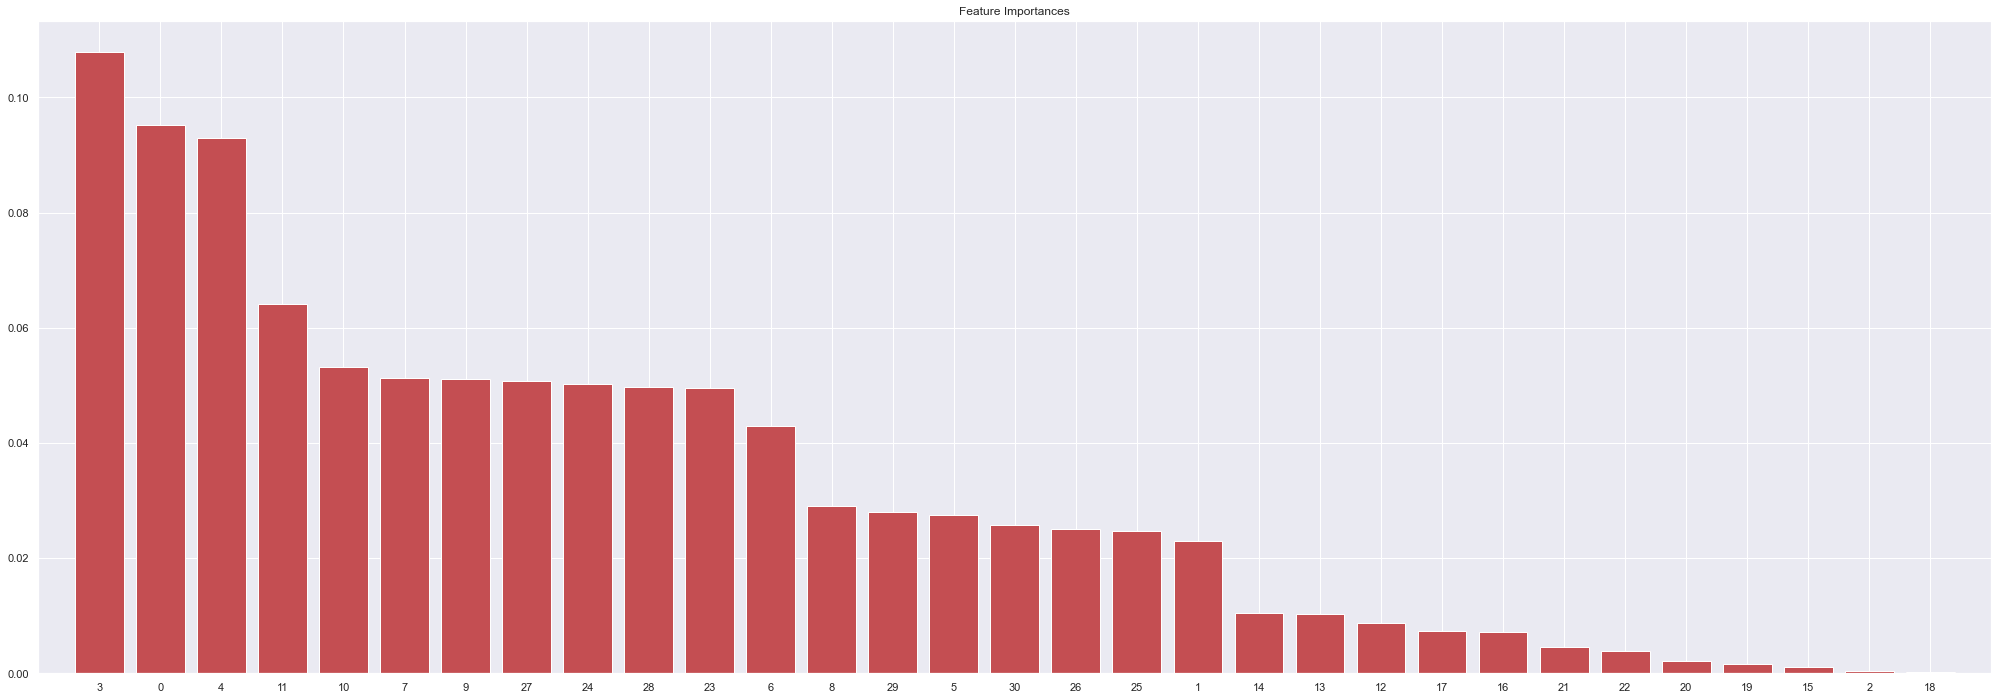

In [22]:
# plot the impurity-base feature importance of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [39]:
# features with more than 4% importance
cols_selected_1 = df[df['importance'] >= 0.04]['feature'].values.tolist()
cols_selected_1

['age',
 'days_from_account_created_until_first_booking',
 'day_first_booking',
 'year_account_created',
 'day_account_created',
 'week_of_year_account_created',
 'affiliate_channel',
 'first_affiliate_tracked',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_account_created_sin',
 'day_account_created_cos']

In [33]:
# features with more than 2% importance
cols_selected_2 = df[df['importance'] >= 0.02]['feature'].values.tolist()
cols_selected_2

['age',
 'signup_flow',
 'days_from_account_created_until_first_booking',
 'day_first_booking',
 'day_of_week_first_booking',
 'year_account_created',
 'day_account_created',
 'day_of_week_account_created',
 'week_of_year_account_created',
 'affiliate_channel',
 'first_affiliate_tracked',
 'week_of_year_account_created_sin',
 'week_of_year_account_created_cos',
 'day_of_week_first_booking_sin',
 'day_of_week_first_booking_cos',
 'day_account_created_sin',
 'day_account_created_cos',
 'day_of_week_account_created_sin',
 'day_of_week_account_created_cos']

# 11. ML Models

In [45]:
df11 = df10[cols_selected_1 + ['country_destination']].copy()

In [46]:
X = df11.drop('country_destination', axis=1)
y = df11['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [47]:
X_train

,age,days_from_account_created_until_first_booking,day_first_booking,year_account_created,day_account_created,week_of_year_account_created,affiliate_channel,first_affiliate_tracked,week_of_year_account_created_sin,week_of_year_account_created_cos,day_account_created_sin,day_account_created_cos
537139,-0.590742,0.160920,29,1.00,9,23,5.512895,5.615767,0.354605,-9.350162e-01,0.968077,-0.250653
637199,-0.438603,-0.057471,13,0.50,13,33,5.671073,5.615767,-0.748511,-6.631227e-01,0.485302,-0.874347
636256,-0.666811,-0.057471,8,0.50,8,23,5.411566,5.367575,0.354605,-9.350162e-01,0.998717,-0.050649
292791,-0.514672,-0.057471,13,0.75,13,11,5.512895,5.538512,0.970942,2.393157e-01,0.485302,-0.874347
68643,0.702441,-0.057471,9,0.75,9,41,4.377661,5.538512,-0.970942,2.393157e-01,0.968077,-0.250653
...,...,...,...,...,...,...,...,...,...,...,...,...
282558,-0.286464,-0.045977,30,0.75,28,13,5.824866,5.367575,1.000000,6.123234e-17,-0.571268,0.820763
599350,-0.438603,-0.045977,13,0.50,11,46,5.512895,5.538512,-0.663123,7.485107e-01,0.790776,-0.612106
655237,-0.514672,-0.034483,11,0.25,9,36,5.512895,5.538512,-0.935016,-3.546049e-01,0.968077,-0.250653
370219,1.006719,-0.022989,16,0.50,13,15,5.512895,5.538512,0.970942,-2.393157e-01,0.485302,-0.874347


## 6.1. Baseline Model

***random*** — Generate pseudo-random numbers:

random.choices(population, weights=None, *, cum_weights=None, k=1)
***Return a k sized list of elements chosen from the population with replacement***. If the population is empty, raises IndexError.

***If a weights sequence is specified, selections are made according to the relative weights***. Alternatively, if a cum_weights sequence is given, the selections are made according to the cumulative weights (perhaps computed using itertools.accumulate()). For example, the relative weights [10, 5, 30, 5] are equivalent to the cumulative weights [10, 15, 45, 50]. Internally, the relative weights are converted to cumulative weights before making selections, so supplying the cumulative weights saves work.

***If neither weights nor cum_weights are specified, selections are made with equal probability***. If a weights sequence is supplied, it must be the same length as the population sequence. It is a TypeError to specify both weights and cum_weights.

The weights or cum_weights can use any numeric type that interoperates with the float values returned by random() (that includes integers, floats, and fractions but excludes decimals). Behavior is undefined if any weight is negative. A ValueError is raised if all weights are zero.

For a given seed, the choices() function with equal weighting typically produces a different sequence than repeated calls to choice(). The algorithm used by choices() uses floating point arithmetic for internal consistency and speed. The algorithm used by choice() defaults to integer arithmetic with repeated selections to avoid small biases from round-off error.

In [178]:
# population list
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
# list of weights in the same order as population
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
# size of the list generated
k_num = y_test.shape[0]

yhat_random = random.choices(population = country_destination_list, weights=country_destination_weights, k=k_num)

Accuracy: 0.3610159817351598
Balanced Accuracy: 0.08360302410029193
Kappa Score: 0.001987976944519576
              precision    recall  f1-score   support

          AU       0.01      0.01      0.01        87
          CA       0.01      0.01      0.01       216
          DE       0.01      0.01      0.01       164
          ES       0.00      0.00      0.00       319
          FR       0.03      0.02      0.03       736
          GB       0.01      0.01      0.01       361
          IT       0.03      0.02      0.02       420
         NDF       0.45      0.45      0.45     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.07      0.07      0.07      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

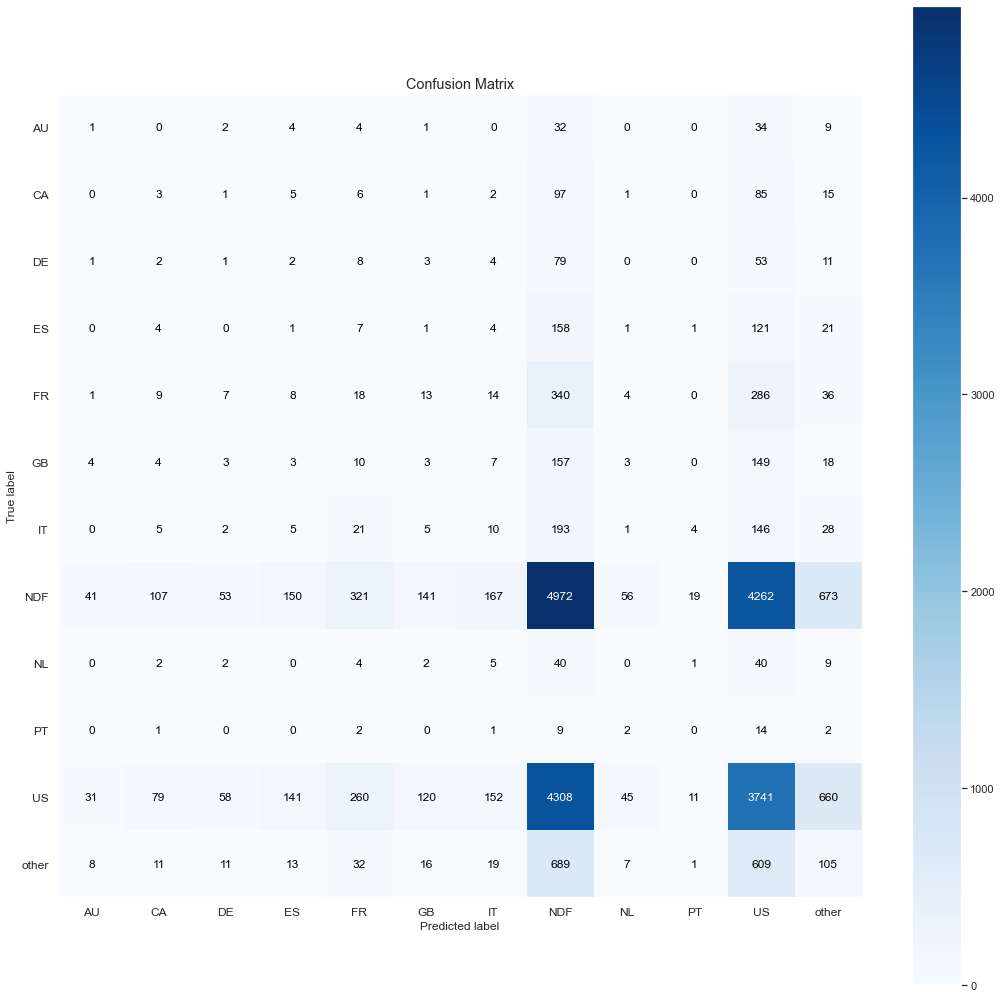

In [179]:
# BASELINE MODEL PERFORMANCE
acc_random = m.accuracy_score(y_test, yhat_random)
balance_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
kappa_random = m.cohen_kappa_score(y_test, yhat_random)

# print
print('Accuracy: {}'.format(acc_random))
print('Balanced Accuracy: {}'.format(balance_acc_random))
print('Kappa Score: {}'.format(kappa_random))
print(m.classification_report(y_test, yhat_random))

# confusion matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(18,18))

## 6.2. Neural Network

In [48]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [184]:
y_train_nn.shape

(98108, 12)

In [183]:
X_train.shape

(98108, 120)

In [49]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit(X_train, y_train_nn, epochs=50)

Epoch 1/50
16435/16435 [==============================] - 43s 3ms/step - loss: 2.1664 - accuracy: 0.2175
Epoch 2/50
16435/16435 [==============================] - 32s 2ms/step - loss: 2.0888 - accuracy: 0.2549
Epoch 3/50
16435/16435 [==============================] - 28s 2ms/step - loss: 2.0568 - accuracy: 0.2691
Epoch 4/50
16435/16435 [==============================] - 26s 2ms/step - loss: 2.0370 - accuracy: 0.2785
Epoch 5/50
16435/16435 [==============================] - 26s 2ms/step - loss: 2.0226 - accuracy: 0.2847
Epoch 6/50
16435/16435 [==============================] - 32s 2ms/step - loss: 2.0120 - accuracy: 0.2890
Epoch 7/50
16435/16435 [==============================] - 35s 2ms/step - loss: 2.0041 - accuracy: 0.2921
Epoch 8/50
16435/16435 [==============================] - 31s 2ms/step - loss: 1.9990 - accuracy: 0.2934
Epoch 9/50
16435/16435 [==============================] - 33s 2ms/step - loss: 1.9938 - accuracy: 0.2953
Epoch 10/50
16435/16435 [==============================

In [50]:
# prediction
pred_nn = model.predict(X_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.3142550731692476
Balanced Accuracy: 0.3136769451184906
Kappa Score: 0.25189951446231795
              precision    recall  f1-score   support

          AU       0.25      0.57      0.35     11001
          CA       0.20      0.30      0.24     10969
          DE       0.23      0.23      0.23     11062
          ES       0.19      0.13      0.16     11002
          FR       0.14      0.08      0.10     10874
          GB       0.20      0.10      0.14     10911
          IT       0.18      0.09      0.12     10861
         NDF       1.00      1.00      1.00     10982
          NL       0.22      0.31      0.25     10720
          PT       0.47      0.73      0.57     11065
          US       0.23      0.17      0.20     10949
       other       0.18      0.05      0.08     11080

    accuracy                           0.31    131476
   macro avg       0.29      0.31      0.29    131476
weighted avg       0.29      0.31      0.29    131476



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

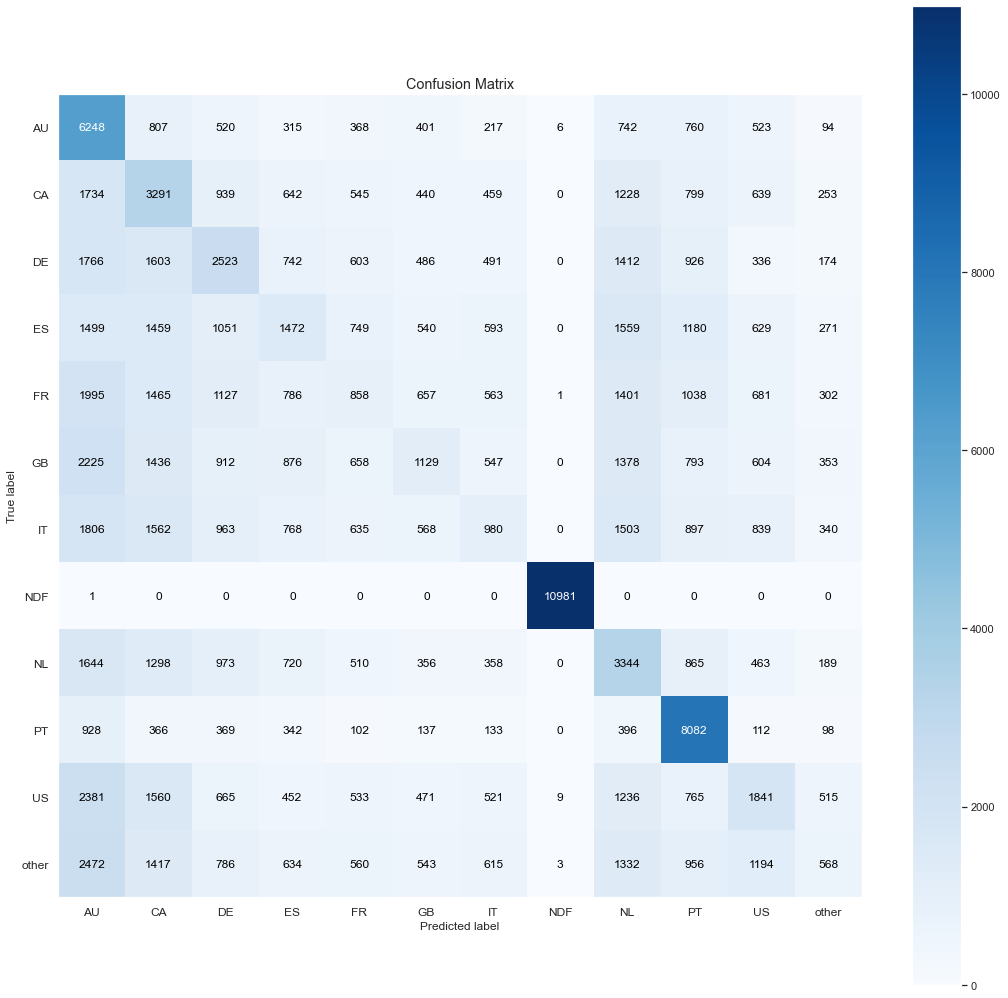

In [51]:
# scores
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat_nn)
kappa_nn = m.cohen_kappa_score(y_test, yhat_nn)

# print
print('Accuracy: {}'.format(acc_nn))
print('Balanced Accuracy: {}'.format(balance_acc_nn))
print('Kappa Score: {}'.format(kappa_nn))
print(m.classification_report(y_test, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(18,18)) 

## NN perfomance - Cross-Validation

In [193]:
x_train = X_train

In [195]:
# generate k-fold for neural network classification:
        # Stratified K-Folds cross-validator, Provides train/test indices to split data in train/test sets. 
        # This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [196]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ), 
                                                  np.round( np.std( balanced_acc_list  ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), 
                                      np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.11 +/- 0.0009
Avg Kappa: 0.1913 +/- 0.0066
